In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [119]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()
# index = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})
# index

In [120]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [121]:
rolling_window = 10
market.connect()
prices = []
skips = 1
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            dividends = market.query("dividends",{"ticker":ticker})
            if dividends.index.size > 0:
                dividends = p.utc_date(dividends)
                price = price.merge(dividends,on=["date","ticker"])
                price["dividend"] = price["rate"].ffill().fillna(0)
            else:
                price["dividend"] = 0
            price = Metric.DISTANCE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Indicator.EMACorr.calculate(price,timeframe=rolling_window)
            price = RiskType.COEFFICIENT_OF_VARIATION.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 19%|██████████████████████████▌                                                                                                               | 2172/11261 [00:50<03:23, 44.76it/s]

index 0 is out of bounds for axis 0 with size 0


 30%|█████████████████████████████████████████▌                                                                                                | 3393/11261 [01:23<03:06, 42.19it/s]

index 0 is out of bounds for axis 0 with size 0


 45%|█████████████████████████████████████████████████████████████▋                                                                            | 5038/11261 [02:02<02:21, 44.09it/s]

index 0 is out of bounds for axis 0 with size 0


 46%|███████████████████████████████████████████████████████████████▊                                                                          | 5207/11261 [02:06<02:11, 46.15it/s]

index 0 is out of bounds for axis 0 with size 0


 48%|██████████████████████████████████████████████████████████████████▎                                                                       | 5416/11261 [02:11<02:11, 44.41it/s]

index 0 is out of bounds for axis 0 with size 0


 48%|██████████████████████████████████████████████████████████████████▌                                                                       | 5436/11261 [02:12<02:26, 39.76it/s]

index 0 is out of bounds for axis 0 with size 0


 51%|██████████████████████████████████████████████████████████████████████▏                                                                   | 5723/11261 [02:19<02:20, 39.36it/s]

index 0 is out of bounds for axis 0 with size 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8782/11261 [03:33<00:54, 45.47it/s]

index 0 is out of bounds for axis 0 with size 0


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9809/11261 [03:57<00:31, 45.71it/s]

index 0 is out of bounds for axis 0 with size 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 10221/11261 [04:07<00:19, 52.89it/s]

index 0 is out of bounds for axis 0 with size 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [04:31<00:00, 41.51it/s]


In [122]:
model_end = 2024
backtest_end = 2025
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [141]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "ema_corr"
                                                            ]
                                                            ,num_of_groups=[3]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[5]
                                                            ,min_prices=[1]
                                                            ,stoplosses=[0.05]
                                                            ,rolling_windows=[rolling_window]
                                                            ,leverages=[1,4]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day"  and "blacklist" in portfolio.selection_type.label  and portfolio.allocation_type.label == "risk" \
            and "distance" in portfolio.grouping_type.value   and portfolio.max_price > portfolio.min_price:
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

8

In [142]:
analysises = []
portfolio_value = 10
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.14s/it]


In [143]:
a = pd.DataFrame(analysises)

In [165]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","timeframe","selection_percentage","stoploss","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,allocation_type,num_of_groups,max_price,min_price,leverage,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio,color,return_to_risk
1,ema_corr,long,DISTANCE,top_blacklist,risk,3,5,1,4,5.706571e+12,1.859837e+13,0.80,9.644829,5.916716e+11,9.644829,5.916716e+11,9.644829,green,9.644829
3,ema_corr,short,DISTANCE,top_blacklist,risk,3,5,1,4,2.025153e+10,3.739603e+10,0.80,7.127565,2.841297e+09,7.127565,2.841297e+09,7.127565,green,7.127565
7,ema_corr,short,DISTANCE,bottom_blacklist,risk,3,5,1,4,8.513281e+07,1.633930e+08,0.80,4.215205,2.019660e+07,4.215205,2.019660e+07,4.215205,green,4.215205
5,ema_corr,long,DISTANCE,bottom_blacklist,risk,3,5,1,4,1.109155e+07,9.686079e+07,0.80,9.248053,1.199339e+06,9.248052,1.199339e+06,9.248053,green,9.248053
0,ema_corr,long,DISTANCE,top_blacklist,risk,3,5,1,1,1.876211e+04,3.435679e+04,0.95,5.715047,3.282931e+03,5.714613,3.282844e+03,5.714765,green,5.715047
2,ema_corr,short,DISTANCE,top_blacklist,risk,3,5,1,1,1.032307e+03,1.296523e+03,0.95,4.452895,2.318283e+02,4.446743,2.317218e+02,4.448788,green,4.452895
4,ema_corr,long,DISTANCE,bottom_blacklist,risk,3,5,1,1,2.356529e+02,6.382477e+02,0.95,4.709072,5.004232e+01,4.680573,4.992520e+01,4.691554,green,4.709072
6,ema_corr,short,DISTANCE,bottom_blacklist,risk,3,5,1,1,2.101424e+02,2.603108e+02,0.95,3.715866,5.655275e+01,3.690648,5.644262e+01,3.697848,green,3.715866


In [166]:
# orivault.cloud_connect()
# orivault.drop("results")
# orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
# orivault.disconnect()

In [156]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

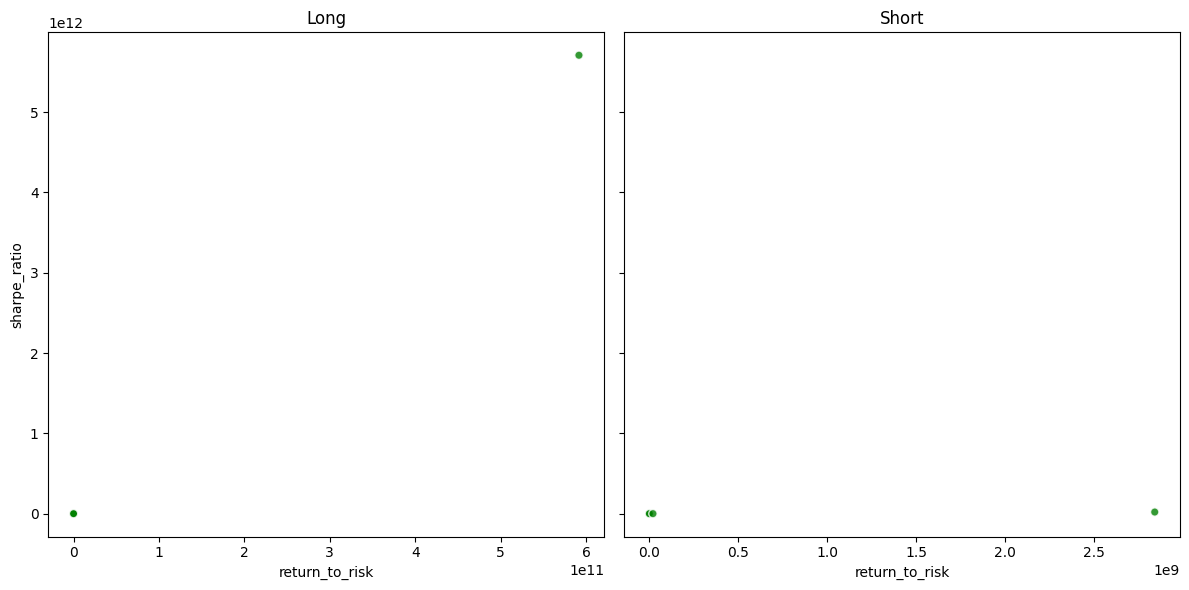

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [158]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

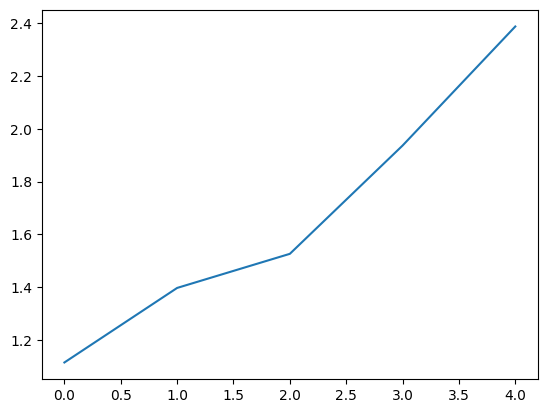

In [159]:
portfolio["weekday"] = portfolio["date"].dt.weekday
averaged_portfolio = portfolio.groupby("weekday").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["weighted_return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()

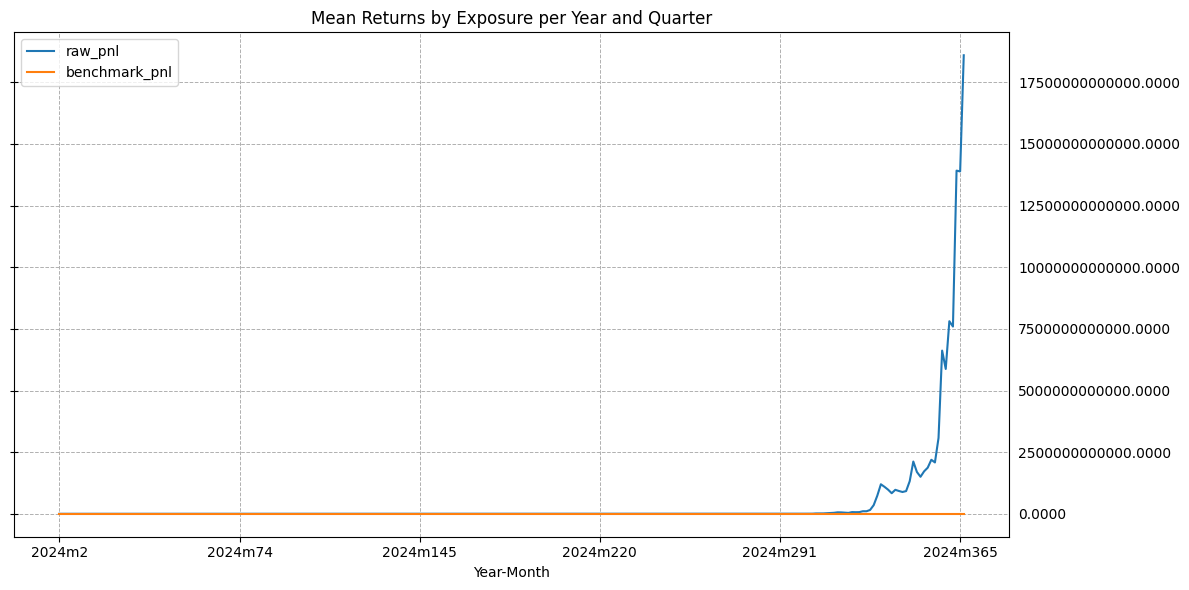

In [160]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [161]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
BNZI,1.474702
PULM,0.945662
CTM,0.915646
MNPR,0.905854
XTLB,0.900441
...,...
LMFA,-0.127406
LOBO,-0.129235
XYLO,-0.133386


In [162]:
portfolio.sort_values("date")

,index,year,day,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,week,weekday,Year-Month
0,0,2024,2,2024-01-02 00:00:00+00:00,1.396767,1.396767,1.396767e+00,1.396767e+00,166.11,1.000000,1,1,1,1,2024m2
1,1,2024,3,2024-01-03 00:00:00+00:00,1.005260,1.005260,1.404114e+00,1.404114e+00,165.39,0.995666,1,1,1,2,2024m3
2,2,2024,4,2024-01-04 00:00:00+00:00,0.976586,0.976586,1.371237e+00,1.371237e+00,166.48,1.002227,1,1,1,3,2024m4
3,3,2024,5,2024-01-05 00:00:00+00:00,1.435970,1.435970,1.969055e+00,1.969055e+00,167.32,1.007284,1,1,1,4,2024m5
4,4,2024,8,2024-01-08 00:00:00+00:00,1.093187,1.093187,2.152546e+00,2.152546e+00,167.07,1.005779,1,1,2,0,2024m8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,247,2024,359,2024-12-24 00:00:00+00:00,1.329612,1.329612,2.396820e+12,7.811511e+12,239.46,1.441575,12,4,52,1,2024m359
248,248,2024,361,2024-12-26 00:00:00+00:00,0.972274,0.972274,2.330366e+12,7.594931e+12,240.28,1.446511,12,4,52,3,2024m361
249,249,2024,362,2024-12-27 00:00:00+00:00,1.832672,1.832672,4.270797e+12,1.391902e+13,238.34,1.434832,12,4,52,4,2024m362
250,250,2024,365,2024-12-30 00:00:00+00:00,0.997677,0.997677,4.260876e+12,1.388668e+13,236.51,1.423816,12,4,1,0,2024m365


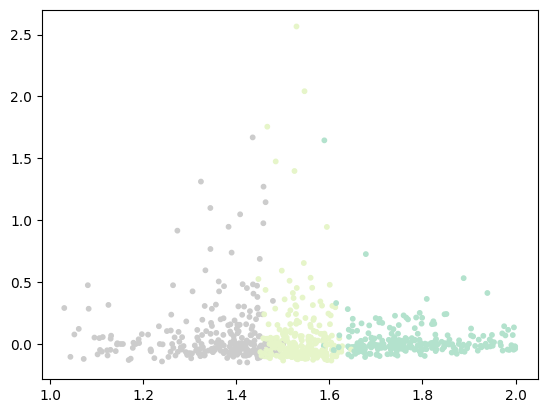

In [163]:
plt.scatter(trades["distance"],trades["return"],s=10,c=trades["group_percentile"].astype(int)*10,cmap="Pastel2")
plt.show()

In [164]:
trades.tail(20)

,year,day,ticker,date,adjclose,sell_price,distance,ema_corr,risk,group_percentile,...,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter,week
736,2024,92,AMLX,2024-04-01 00:00:00+00:00,2.7100,2.6200,1.561542,0.267940,1.051389,2,...,1.0,0.228043,0.966790,0.966790,0.966790,-0.030294,-0.030294,4,2,14
737,2024,92,NXL,2024-04-01 00:00:00+00:00,1.9000,2.8700,1.344626,0.341149,0.637986,3,...,1.0,0.375811,1.510526,1.510526,1.510526,0.767446,0.767446,4,2,14
738,2024,93,IMNN,2024-04-02 00:00:00+00:00,1.7500,1.3900,1.862833,0.283164,0.321227,1,...,1.0,0.345660,0.794286,0.950000,0.950000,-0.069132,-0.069132,4,2,14
739,2024,93,XLO,2024-04-02 00:00:00+00:00,1.4800,1.3000,1.518663,0.315593,0.315689,2,...,1.0,0.351724,0.878378,0.950000,0.950000,-0.070345,-0.070345,4,2,14
740,2024,93,CXAI,2024-04-02 00:00:00+00:00,4.4800,4.9400,1.401264,0.380992,0.366918,3,...,1.0,0.302616,1.102679,1.102679,1.102679,0.124289,0.124289,4,2,14
741,2024,94,NXL,2024-04-03 00:00:00+00:00,2.4000,2.1500,1.689953,0.320576,0.875194,1,...,1.0,0.140117,0.895833,0.950000,0.950000,-0.028023,-0.028023,4,2,14
742,2024,94,AMLX,2024-04-03 00:00:00+00:00,2.6300,2.6100,1.598172,0.253127,1.074010,2,...,1.0,0.114180,0.992395,0.992395,0.992395,-0.003473,-0.003473,4,2,14
743,2024,94,HYMC,2024-04-03 00:00:00+00:00,3.6700,3.2600,1.423670,0.229063,0.164449,3,...,1.0,0.745703,0.888283,0.950000,0.950000,-0.149141,-0.149141,4,2,14
744,2024,95,FLGC,2024-04-04 00:00:00+00:00,2.2000,2.3800,1.641725,0.182395,0.349414,1,...,1.0,0.353144,1.081818,1.081818,1.081818,0.115574,0.115574,4,2,14
745,2024,95,NEOV,2024-04-04 00:00:00+00:00,1.9000,2.0900,1.578723,0.292976,0.328672,2,...,1.0,0.375429,1.100000,1.100000,1.100000,0.150172,0.150172,4,2,14
